In [2]:
import sys
import pickle 

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
from Functions import renormalize, scomplex, plotting
import matplotlib.pyplot as plt
import networkx as nx

import xgi
from itertools import combinations

plt.rcParams["text.usetex"] = True


colors = ["#003F5C","#2F4B7C","#665191","#A05195","#D45087","#F95D6A","#FF7C43","#FFA600"]
colors_sequential = colors + colors + colors + colors 
colors = ["#02405c", "#fea600", "#a20655", "#5e96c5", "#4b3596", "#fa6ca9", "#8d6cf6"]
colors_curves = colors+ colors+ colors+ colors


In [55]:
def adjacency_of_order_hg(sc,k,l):
    # sc: hypergraph object
    # k: order of the diffusing simplices
    # l: order of the interaction simplices

    keys = ["nodes", "edges", "faces", "tetrahedra", "4-simplices"]
    nk = sc[f"n{k}"]
    adj = np.zeros((nk,nk),dtype = int)

    if l < k: 
       
        diff_units = sc[keys[k]]
        
        if l == 0:
            for i in range(nk):
                for j in range(i+1,nk):
                    intersection = (set(diff_units[i,:]) & set(diff_units[j,:]))
                    adj[i,j] = 2*len(intersection)
                    
        else: 
            edge_dict, face_dict, tet_dict = scomplex.make_dict(sc)
            dicts = [{(i,):i for i in range(sc["n0"])},edge_dict,face_dict,tet_dict]
            for i in range(nk):
                for j in range(i+1,nk):
                    intersection = (set(diff_units[i,:]) & set(diff_units[j,:]))
                    combs = list(combinations(intersection, l+1))
                    for c in combs:
                        if c in dicts[l]:
                            adj[i,j] += 2
                

    elif l > k:
        edge_dict, face_dict, tet_dict = scomplex.make_dict(sc)
        dicts = [{(i,):i for i in range(sc["n0"])},edge_dict,face_dict,tet_dict]
        for i,simp in enumerate(sc[keys[l]]):
            combs = list(combinations(simp, k+1))
            ncombs = len(combs)
            combs_present = []
            for c in range(ncombs):
                if combs[c] in dicts[k]:
                    combs_present.append(dicts[k][combs[c]])

            for c1 in combs_present:
                for c2 in combs_present:
                    if c2 != c1:
                        adj[c1,c2] += 1

    return (adj + adj.T)//2

def XO_laplacian_hg(sc,k,l):
    A = adjacency_of_order_hg(sc,k,l)
    K = np.sum(A, 0)
    L = np.diag(K) - A
    return L

In [53]:

def induce_simplices_hg(sc, mapnodes):
    # Finds induced simplices in the simplicial complex after its nodes are coarse grained 
    # INPUTS
    # sc: simplicial complex object
    # mapnodes: mapping from each node in sc to the label of its signature
  
    # OUTPUTS
    # new_sc: coarse grained simplicial complex object

    keys = ["edges", "faces", "tetrahedra", "4-simplices"]
    new_sc = {
        "nodes": np.sort(np.unique(mapnodes)),
    }
    new_sc["n0"] = len(new_sc["nodes"])
    new_sc["nodes"] = np.reshape(new_sc["nodes"], (new_sc["n0"], 1))
    for key in keys:
        new_sc[key] = []

    # Connect supernodes with hyperedges
    for order, key in enumerate(keys):
        for i in range(sc[f"n{order+1}"]):
            nodes = mapnodes[sc[key][i, :]]
            un = np.unique(nodes)
            lun = len(un)
            if lun > 1:
                new_sc[keys[lun-2]].append(un)

    # Remove duplicate hyperedges
    for order, key in enumerate(keys):
        if len(new_sc[key]) != 0:
            new_sc[key] = np.unique(
                np.sort(np.array(new_sc[key], dtype=int), axis=1), axis=0
            )
            new_sc[f"n{order+1}"] = new_sc[key].shape[0]
        else:
            new_sc[key] = np.zeros((0, order+2), dtype=int)
            new_sc[f"n{order+1}"] = 0

    return new_sc

def renormalize_single_step_hg(sc,tau, diff_order =0, int_order = 1, D = None, U = None, VERBOSE = True):
    # Performs a single step of higher-order Laplacian renormalization 
    # INPUTS
    # sc: simplicial complex object
    # tau: diffusion time
    # diff_order: order of the diffusing simplices
    # int_order: order of the interaction simplices
    # D: the list of Laplacian eigenvlaues, if None computes them from scratch
    # U: the list of Laplacian eigenvectors, if None computes them from scratch 
    # VERBOSE: if True print the number of nodes after the coarse-graining

    # OUTPUTS
    # new_sc: renormalized simplicial complex
    # mapnodes: array associating to each node in sc the node in new_sc it is mapped to
    # clusters: cluster label of each simplex of order diff_order
  

    if (D is None) or (U is None):
        L = XO_laplacian_hg(sc, diff_order, int_order)
        D,U = np.linalg.eigh(L)

    rho  = np.abs(U@np.diag(np.exp(-tau*D))@U.T)

    Gv = nx.Graph()
    Gv.add_nodes_from([i for i in range(sc[f"n{diff_order}"])])
    for i in range(sc[f"n{diff_order}"]):
        for j in range(i+1,sc[f"n{diff_order}"]):
            if rho[i,j] >= min(rho[i,i],rho[j,j]):
                Gv.add_edge(i,j)

        
    idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
    clusters = [idx_components[u] for u in Gv.nodes]

    mapnodes,__ = renormalize.coarse_grain(sc,diff_order,clusters,np.max(clusters)+1)
    new_sc = induce_simplices_hg(sc, mapnodes)

    if VERBOSE:
        print(new_sc["n0"])

        
    return new_sc, mapnodes, clusters  


In [34]:
H = xgi.load_xgi_data(r"email-eu", max_order=3)

Convert xgi hypergraph to our format

In [35]:
H.cleanup()

sc = {}
sc["nodes"] = np.sort(np.array([H.nodes]).T,0)
sc["n0"] = sc["nodes"].shape[0]
keys = ["edges","faces","tetrahedra","4-simplices"]

for k in keys:
    sc[k] = []
for e in H.edges.members():
    sc[keys[len(e)-2]].append(list(e))

for i,k in enumerate(keys):
    if len(sc[k]) == 0:
        sc[k] = np.zeros((0,i+2))
    else:
        sc[k] = np.unique(np.sort(np.array(sc[k]),1),axis =0)
    
    sc[f"n{i+1}"] = sc[k].shape[0] 



In [43]:
# Define strings which specify the Laplacians to consider

#laplacians_types = ["01","02","10","12","20","21"]
laplacians_types = ["01","02","03","10","12","13","20","21","23","30","31","32"]
laplacians_types = ["01","02","03","20","21","23","30","31","32"]

# Compute eigenvalues of the Laplacians and their specific heat curves

taumin = -3 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

sp_heats = []

for l in laplacians_types:  
    print(f"L_({l[0]},{l[1]})")  
    L = diffusion_laplacian_hg(sc, k=int(l[0]), l=int(l[1]))
    D,U = np.linalg.eigh(L)
    D = np.abs(D)

    specific_heat,tau_space, __ = renormalize.compute_entropic_C(D,taumin,taumax,ntau)
    sp_heats.append(specific_heat)


L_(0,1)
L_(0,2)
L_(0,3)
L_(2,0)
L_(2,1)
L_(2,3)
L_(3,0)
L_(3,1)
L_(3,2)


(array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
        1.e+02]),
 [Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$')])

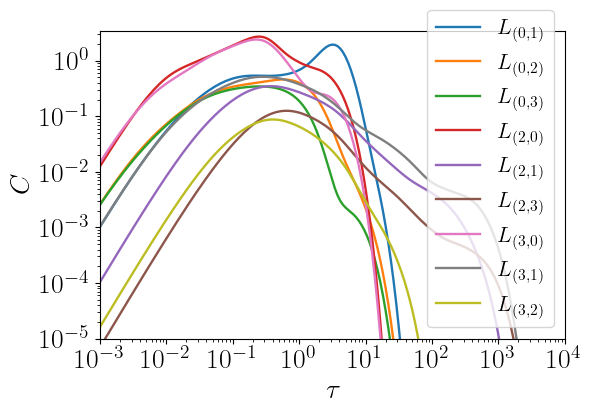

In [48]:
cols  = colors_curves
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))
for i in range(len(laplacians_types)):
    ax.loglog(tau_space,sp_heats[i],linewidth = 1.7,alpha = 1)


ax.set_ylim([10**-5,3.5])
ax.set_xlim([10**-3,10**4])

ax.legend([names[i] for i in range(len(laplacians_types))],fontsize = 16)


ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

#ax.vlines(x = 4,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])